In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
import os
import pandas as pd
# import pickle5 as pickle

import sys
sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

Warning no robinhood utils.


In [3]:
sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

In [4]:
torch.random.manual_seed(400)

# Header

In [5]:
ntest = 200
ntrain = 200
span = "5year"
interval = 'day'
T = 5.

In [6]:
# with open("../../spdr-data/XLF.pkl", "rb") as handle:
#     raw_data = pickle.load(handle)

In [7]:
raw_data = pd.read_pickle("../../spdr-data/XLF.pkl")

In [8]:
tckrs = np.unique(raw_data["symbol"])

## Data Setup

In [9]:
data_list = []
for i, tckr in enumerate(tckrs):
    data = raw_data[raw_data["symbol"] == tckr]

    y = torch.FloatTensor(data['close_price'].to_numpy())
    data_list.append(y)

ts = torch.linspace(0, T, data.shape[0]) + 1
dt = ts[1] - ts[0]
full_data = torch.stack(data_list)


In [10]:
full_returns = torch.log(full_data[..., 1:] / full_data[..., :-1])

In [11]:
device = torch.device("cpu")

In [12]:
# torch.cuda.set_device(device)

## Now apply GCPV

In [13]:
%pdb

Automatic pdb calling has been turned ON


In [24]:
from voltron.models import MultitaskVariationalGP
from gpytorch.priors import LKJCovariancePrior, SmoothedBoxPrior

def get_and_fit_mtgpcv(train_x, log_returns):
    likelihood = VolatilityGaussianLikelihood(batch_shape=[log_returns.shape[0]], param="exp")

    # corresponds to ICM
    model = MultitaskVariationalGP(
        inducing_points=train_x, 
        covar_module=BMKernel().to(device), learn_inducing_locations=False,
        num_tasks = log_returns.shape[0], 
        prior=LKJCovariancePrior(eta=5.0, n=log_returns.shape[0], sd_prior=SmoothedBoxPrior(0.05, 1.0))
    )
    model = model.to(device)
    model.initialize_variational_parameters(likelihood=likelihood, x=train_x, y=log_returns.t())
    
    model = model.to(device)
    likelihood = likelihood.to(device)

    # this is for running the notebook in our testing framework
    import os
    smoke_test = ('CI' in os.environ)
#     training_iterations = 2 if smoke_test else 300
    training_iterations = 1


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {"params": model.parameters()}, 
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    # num_data refers to the number of training datapoints
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_x.shape[0])
    
    batched_train_x = train_x#[:-1]
    
    print_every = 50
    for i in range(training_iterations):
        # Zero backpropped gradients from previous iteration
        optimizer.zero_grad()
        # Get predictive output
        output = model(batched_train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, log_returns.t())
        loss.backward()
        if i % print_every == 0:
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        
    model.eval();
    likelihood.eval();
    predictive = model(train_x)
    # pred_scale = likelihood(predictive).scale.mean(0).detach()
    samples = likelihood(predictive).scale.detach()
    return samples.mean(0) / dt**0.5

In [25]:
from voltron.models import MultitaskBMGP
from gpytorch.likelihoods import MultitaskGaussianLikelihood

def get_and_fit_volmodel(train_x, pred_scale):
    prior = LKJCovariancePrior(eta=5.0, n=len(tckrs), sd_prior=SmoothedBoxPrior(0.05, 1.0))

    vol_lh = MultitaskGaussianLikelihood(num_tasks=pred_scale.shape[-1])
    vol_lh.noise.data = torch.tensor([1e-6])
    vol_model = MultitaskBMGP(train_x, pred_scale.log(), vol_lh, prior=prior).to(device)

    optimizer = torch.optim.Adam([
        {'params': vol_model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(vol_lh, vol_model)

    for i in range(500):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = vol_model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, pred_scale.log())
        loss.backward()
        if i % 50 == 0:
            print(loss.item(), vol_model.covar_module.data_covar_module.raw_vol.item())
        optimizer.step()

    print((vol_model.covar_module.data_covar_module.raw_vol))
    
    return vol_model, vol_lh

In [26]:
from voltron.means import LogLinearMean

def get_and_fit_datamodel(train_x, train_y, pred_scale, vol_model, vol_lh):
    
    voltron_lh = gpytorch.likelihoods.GaussianLikelihood().to(device)
    voltron = VoltronGP(train_x, train_y.log(), voltron_lh, pred_scale.t()).to(device)
    # voltron.mean_module = gpytorch.means.LinearMean(1, batch_shape=torch.Size((6,)))
    voltron.mean_module = LogLinearMean(input_size=1, batch_shape=torch.Size((pred_scale.shape[1],))).to(device)
    voltron.mean_module.initialize_from_data(train_x, train_y.log())
    voltron.likelihood.raw_noise.data = torch.tensor([1e-6]).to(device)
    voltron.vol_lh = vol_lh.to(device)
    voltron.vol_model = vol_model.to(device)

    grad_flags = [False, True, True, True, *[False] * len(list(vol_model.named_parameters()))]

    for idx, (n, p) in enumerate(voltron.named_parameters()):
        # print(n)
        p.requires_grad = grad_flags[idx]

    voltron.train();
    voltron_lh.train();
    voltron.vol_lh.train();
    voltron.vol_model.train();

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': voltron.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(voltron_lh, voltron)

    for i in range(500):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = voltron(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y.log()).sum()
        loss.backward()
        if i % 50 == 0:
            print(loss.item())
        optimizer.step()
    return voltron

In [27]:
def predict(test_x, voltron, nvol=10, npx=10, num_tasks=len(tckrs)):
    vol_paths = torch.zeros(num_tasks, nvol, test_x.shape[0])
    px_paths = torch.zeros(num_tasks,  npx*nvol, test_x.shape[0])

    voltron.vol_model.eval();
    voltron.eval();

    for vidx in range(nvol):
        print(vidx)
        vol_pred = voltron.vol_model(test_x).sample().exp()
        vol_paths[:, vidx, :] = vol_pred.detach().t().cpu()

        px_pred = voltron.GeneratePrediction(test_x, vol_pred.t(), npx)
        px_pred = px_pred.exp()
        px_paths[:, vidx*npx:(vidx*npx+npx), :] = px_pred.detach().transpose(-1, -2).cpu()
    return px_paths, vol_paths

In [28]:
train_splits = list(range(252, data.shape[0], int(252/2)))
eval_splits = list(range(252+int(252/2), data.shape[0], int(252/2))) + [-1]
print(len(train_splits), len(eval_splits))

8 8


In [29]:
train_splits.insert(0, 0)

In [30]:
train_splits

[0, 252, 378, 504, 630, 756, 882, 1008, 1134]

In [31]:
ts = ts.to(device)
full_returns = full_returns.to(device)
full_data = full_data.to(device)

In [32]:
ts = ts[1:]

In [33]:
covar_list = []
x_list = []
v_list = []
# for i in range(len(eval_splits)):
i = 0

train_start = train_splits[i]
train_end = train_splits[i+1]
test_end = eval_splits[i]

print("Now running ", train_start, train_end)
torch.cuda.empty_cache()

pred_scale = get_and_fit_mtgpcv(ts[train_start:train_end], full_returns[:,train_start:train_end])
vol_model, vol_lh = get_and_fit_volmodel(ts[train_start:train_end], pred_scale)
model = get_and_fit_datamodel(
    ts[train_start:train_end], full_data[:,train_start:train_end], pred_scale, vol_model, vol_lh
)

est_covar = model.vol_model.covar_module.task_covar_module.covar_matrix.evaluate().cpu()
x_paths, v_paths = predict(ts[train_end:test_end], model)

covar_list.append(est_covar)
x_list.append(x_paths)
v_list.append(v_paths)

del model

Now running  0 252
Iter 1/1 - Loss: 164.411
1.1449265480041504 -1.3862943649291992


/home/greg_b/miniconda3/envs/rpp/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


0.928978681564331 -1.0333786010742188
0.709404468536377 -1.0833930969238281
0.4720747470855713 -1.344559669494629
0.22222964465618134 -1.66531503200531
-0.0330703966319561 -1.9696232080459595
-0.28592270612716675 -2.22033953666687
-0.5303149819374084 -2.389354944229126
-0.7619909644126892 -2.475860834121704
-0.9778973460197449 -2.4871413707733154
Parameter containing:
tensor([-2.4095], requires_grad=True)
22.37977409362793
22.356121063232422
22.344392776489258
22.33585548400879
22.329547882080078
22.324800491333008
22.321184158325195
22.31840705871582
22.31624984741211
22.314552307128906
0
1
2
3
4
5
6


KeyboardInterrupt: 

> /home/greg_b/miniconda3/envs/rpp/lib/python3.8/site-packages/gpytorch/lazy/kronecker_product_lazy_tensor.py(43)_matmul()
     41         factor = lazy_tensor._matmul(res)
     42         factor = factor.view(*output_batch_shape, lazy_tensor.size(-2), -1, num_cols).transpose(-3, -2)
---> 43         res = factor.reshape(*output_batch_shape, -1, num_cols)
     44     return res
     45 



ipdb>  q


In [34]:
pred_scale.shape

torch.Size([252, 30])

In [33]:
full_returns[:,train_start:train_end]

tensor([[-0.0142,  0.0045,  0.0072,  ...,  0.0000,  0.0010,  0.0114],
        [-0.0046,  0.0045, -0.0065,  ...,  0.0019,  0.0009,  0.0099],
        [-0.0046, -0.0043, -0.0042,  ...,  0.0022,  0.0008, -0.0038],
        ...,
        [-0.0025,  0.0002, -0.0009,  ...,  0.0079, -0.0026,  0.0027],
        [-0.0121, -0.0007, -0.0030,  ...,  0.0070,  0.0006, -0.0050],
        [-0.0127, -0.0009, -0.0047,  ...,  0.0085,  0.0009, -0.0081]])

In [22]:
quantiles = torch.stack(
    [(x_paths[..., -1] > full_data[:, tend-1].unsqueeze(-1).cpu()
     ).sum(1)/100 for x_paths, tend in zip(x_list, eval_splits)]
)

In [23]:
torch.save(f="finance_mt_preds_3.pt", obj={"quantiles": quantiles, "x_paths": x_list, "v_paths": v_list, "covar": covar_list})

In [24]:
import pandas as pd

In [25]:
df = pd.DataFrame({"quantiles": quantiles.reshape(-1).numpy(), "date": np.repeat([np.array(eval_splits)],30)})

In [26]:
df["date"] = df["date"] / (1259/5)

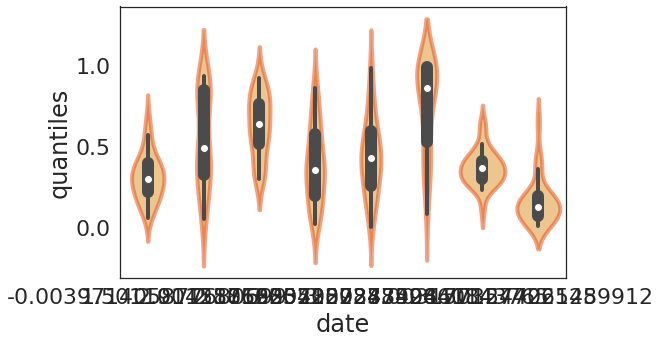

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
violins = sns.violinplot(x='date', y='quantiles', data=df, color=palette[-1])
for violin in violins.collections[::2]:
    violin.set_alpha(0.5)
    violin.set_edgecolor(palette[-2])

<Figure size 576x720 with 0 Axes>

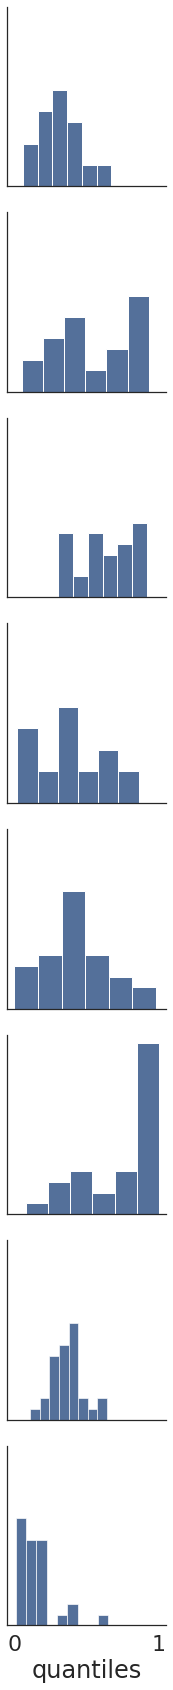

In [28]:
plt.figure(figsize = (8, 10))
ridge_plot = sns.FacetGrid(df, row="date")
# Use map function to make density pslot in each element of the grid.
ridge_plot.map(sns.histplot, "quantiles", clip_on=False)
ridge_plot.set_titles("")
ridge_plot.set(yticks=[], ylabel="")
plt.tight_layout()

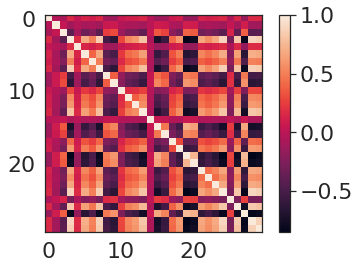

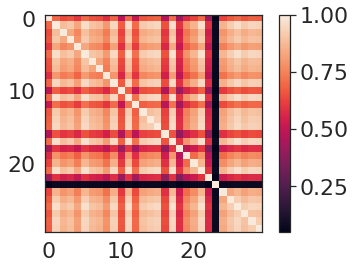

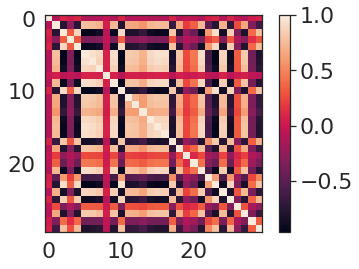

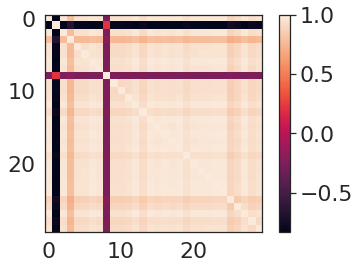

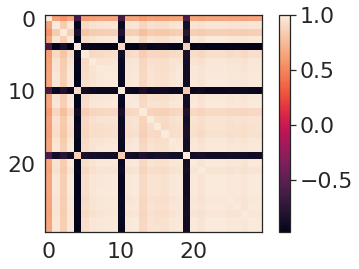

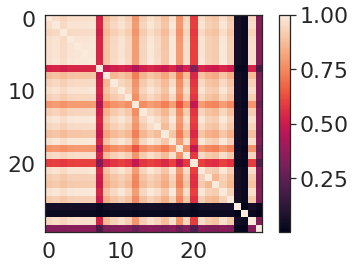

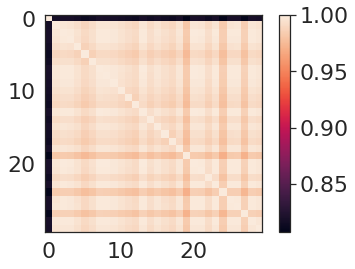

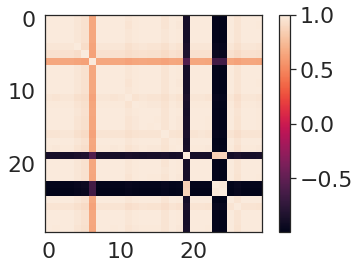

In [29]:
for est_covar in covar_list:
    est_corr = torch.diag(est_covar.diag().sqrt().pow(-1.0)).matmul(est_covar).matmul(
        torch.diag(est_covar.diag().sqrt().pow(-1.0))
    )
    f = plt.imshow(est_corr)
    plt.colorbar(f)
    plt.show()